# Evaluate Policies and Model Checker on Urban Scenarios

**Supported Policies**
    - baseline
    - masked-baseline
    - masked-RL

**Supported Belief Updaters**
    - previous_obs
    - tracker
    
**Supported Scenarios**
    - 1-1 : One car going straight + noisy sensor
    - 1-2 : One car going straight + occlusion
    - 2-1 : One car and one pedestrian interacting
    - 2-2 : One car turning left interacting with the ego vehicle
    - 3 : multiple cars and multiple pedestrian

In [1]:
include("../evaluation/helpers.jl")
include("../src/render_helpers.jl")
set_color_theme(LIGHTTHEME)
AutoViz._colortheme["background"] = colorant"white"
AutoViz._colortheme["CROSSWALK"] = colorant"gray"

┌ Info: Precompiling AutomotiveSensors [9ec66b5e-c605-11e8-1454-ede748df6f96]
└ @ Base loading.jl:1273
┌ Info: Precompiling AutomotivePOMDPs [dca8afc0-c686-11e8-0934-712707da73aa]
└ @ Base loading.jl:1273
┌ Info: Precompiling PedCar [90cf7f26-d5c7-593d-a0e1-4a8367407571]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



In [2]:
rng = MersenneTwister(1);

In [7]:
pomdp, policy, updater, initialscene_scenario = load_policies_and_environment("RL", "tracker", "3");

Evaluating RL policy with tracker updater on scenario 3


## Visualize simulations

In [8]:
policy = FunctionPolicy(s->UrbanAction(-4.0))

FunctionPolicy{var"#150#151"}(var"#150#151"())

In [9]:
@time hist = run_sim(pomdp, policy, updater, initialscene_scenario, rng);
@printf("Simulation: %i steps, %0.3f undiscounted reward ", n_steps(hist), undiscounted_reward(hist))

  8.258659 seconds (6.01 M allocations: 3.072 GiB, 24.35% gc time)
Simulation: 400 steps, 0.000 undiscounted reward 

In [10]:
animate_history(hist, pomdp,
                obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAY["color2"])],
                belief_overlays = b -> [MultipleAgentsBeliefOverlay(b, color=ARGB(0.,0.,1.,0.2))],
                action_overlays = a -> [TextOverlay(text = ["Acc: $(a.acc) m/s^2"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 8.), incameraframe=true)],
#                 ainfo_overlays = ai -> [MultipleInterpolatedBeliefsOverlay(ai[5], pomdp, mdp, pedcar_pomdp, ai[end])],
#                                         TextOverlay(text = ["Probabilities: $([round(p, digits=4) for p in ai[2]])"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 12.), incameraframe=true),
#                                         TextOverlay(text = ["Available Actions: $([a.acc for a in ai[1]])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true)],                
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
#                 extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 12.0),
                speed_factor=2)

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_gXqLG4", 0x0000000000000190, 20.0, nothing)

In [25]:
println(RGB(MONOKAY["color2"]))

RGB{N0f8}(0.655,0.925,0.129)


## Collision Analysis

In [102]:
hist = find_collision(pomdp, policy, updater, initialscene_scenario, rng, n_ep=1000);

Progress:  18%|███████                                  |  ETA: 17:35:08

InterruptException: InterruptException:

In [71]:
b = hist.belief_hist[78]
pcb = create_pedcar_beliefs(pomdp, b)

Dict{Tuple{Int64,Int64,Int64},PedCarRNNBelief} with 9 entries:
  (4, 103, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, 0.…
  (2, 102, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (4, 101, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, 0.…
  (2, 101, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (3, 101, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (3, 102, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (3, 103, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (2, 103, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, -0…
  (4, 102, 1) => PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.365, 1.0, 0.0, 0.…

In [72]:
pedcar_pomdp = policy.policy.problem
mask = policy.mask
compute_probas(pedcar_pomdp, mask, pcb[(2, 101, 1)])

4-element Array{Float64,1}:
 0.9997952222846997
 0.9997952222846997
 0.9997952222846997
 0.999870887782835 

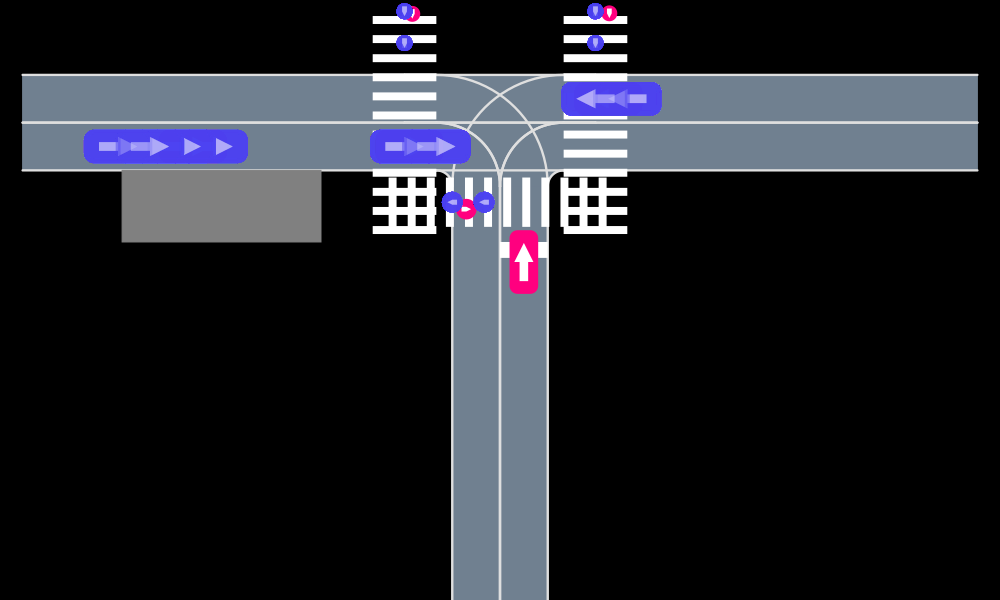

In [78]:
AutoViz.render(hist.state_hist[78], pomdp.env, [MultipleInterpolatedBeliefsOverlay(pcb, pomdp, mask.mdp, pedcar_pomdp, pomdp.models)], cam=FitToContentCamera(0.))

In [85]:
pcbb = pcb[(2,101,1)]
ss = obs_to_scene(pedcar_pomdp, pcbb.predictions[1])
ssmdp = get_mdp_state(mask.mdp, pomdp, ss, PED_ID, CAR_ID)
println(ssmdp.ped)
# AutoViz.render(ss, pomdp.env, cam=FitToContentCamera(0.))

VehicleState(VecSE2({-1.281, -5.621}, -0.047), Frenet(RoadIndex({1, 0.408481}, {19, 1}), 5.719, -0.621, -0.047), 0.887)


In [101]:
itp_states, itp_weights = interpolate_state(mask.mdp, ssmdp)
sss = itp_states[argmax(itp_weights)]
sss.ped

VehicleState(VecSE2({-1.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.428571}, {19, 1}), 6.000, 0.000, 0.000), 1.000)

In [100]:
mod2pi(ssmdp.ped.posF.ϕ)

6.236483401479002

In [97]:
mod(ssmdp.ped.posF.ϕ, pi)

3.0948907478892087

In [94]:
?mod2pi

search: mod2pi



```
mod2pi(x)
```

Modulus after division by `2π`, returning in the range $[0,2π)$.

This function computes a floating point representation of the modulus after division by numerically exact `2π`, and is therefore not exactly the same as `mod(x,2π)`, which would compute the modulus of `x` relative to division by the floating-point number `2π`.

# Examples

```jldoctest
julia> mod2pi(9*pi/4)
0.7853981633974481
```


In [73]:
fieldnames(MultipleInterpolatedBeliefsOverlay)

(:beliefs, :pomdp, :mdp, :pedcar_pomdp, :models)

In [74]:
fieldnames(InterpolatedBeliefOverlay)

UndefVarError: UndefVarError: InterpolatedBeliefOverlay not defined